# Simulation of an $\mathrm{Al_{x}Ga_{1-x}As}$ infra red LED

The following code loads the needed modules.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from   synumses.one_dimension.scharfetter_gummel_bernoulli import bernoulli, jacobian, update_b, first_jacobian, first_update_b, electron_current_density, hole_current_density
import synumses.one_dimension.parameters as parameters

from   synumses.one_dimension.functions import calc_p_density, calc_n_density, calc_recombination, ohm_potential

import synumses.one_dimension.solver as solver


## Definition of the $\mathrm{Al_{x}Ga_{1-x}As}$ material parameters
The mobility, the density of states and $\varepsilon_\mathrm{r}$ depend on the Al content.<br>
The parameter **x** is the Al content.<br>
The mobility is kept constant for convergance reason!<br>
The parameters are plotted.

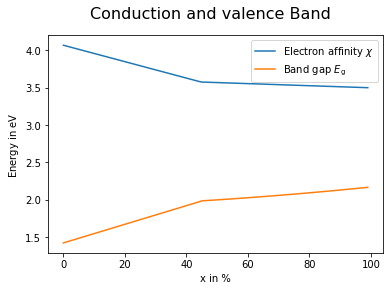

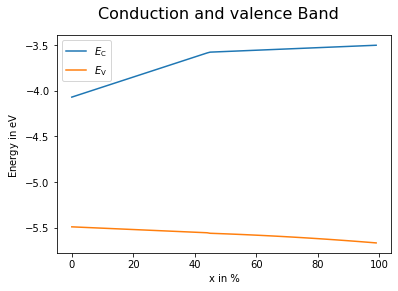

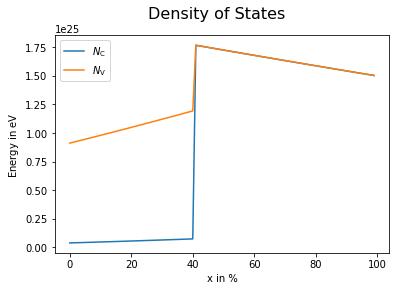

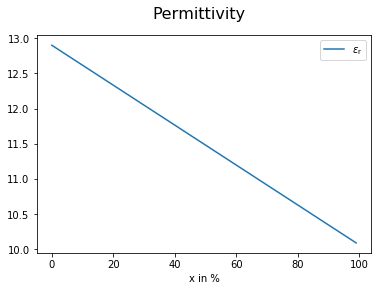

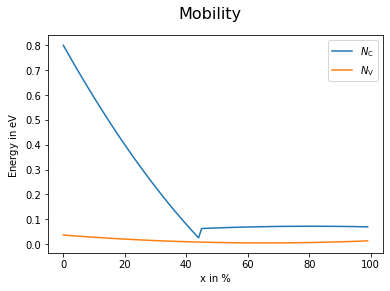

In [2]:
def material_AlGaAs(x):

    T = 300

    if (x<0.45):
            Chi = 4.07 - 1.1*x
            Eg = 1.422 + 1.2475*x
                
            mu_n=(8000 - 22000*x + 10000*x**2)*1E-4
    else:
            Chi  = 3.64 - 0.14*x
            Eg   = 1.9  + 0.124*x + 0.147*x**2
            mu_n = (255 +  1160*x -   720*x**2)*1E-4
    
    
    mu_p = (370-970*x+740*x**2)*1E-4
    
    
    
    if (x<0.41):
        Nc = 4.82E21*T**(3/2)*(0.063 + 0.083*x)**(3/2) 
        Nv = 4.82E21*T**(3/2)*(0.51  + 0.250*x)**(3/2)
    else:
        Nc = 4.82E21*T**(3/2)*(0.85-0.14*x)**(3/2)
        Nv = 4.82E21*T**(3/2)*(0.85-0.14*x)**(3/2)
     
    
    
    Er = 12.90-2.84*x
    
    
    return({"Chi":Chi,
            "Eg":Eg,
            "Nc":Nc,
            "Nv":Nv,
            "Er": Er,
            "mu_n":mu_n,
            "mu_p":mu_p}
          )

Chi = []
Eg = []
Nv = [] 
Nc = []
Er = []
mu_n = []
mu_p = []


for x in np.arange(0, 1, 1E-2):
    
    Chi.append(material_AlGaAs(x)["Chi"])
    Eg.append(material_AlGaAs(x)["Eg"])
    Nv.append(material_AlGaAs(x)["Nv"])
    Nc.append(material_AlGaAs(x)["Nc"])
    Er.append(material_AlGaAs(x)["Er"])
    mu_n.append(material_AlGaAs(x)["mu_n"])
    mu_p.append(material_AlGaAs(x)["mu_p"])
  
Chi = np.array(Chi)
Eg = np.array(Eg)
Nv = np.array(Nv)
Nc = np.array(Nc)
Er = np.array(Er)
mu_p = np.array(mu_p)
mu_n = np.array(mu_n)


#
# Plot electron affinity and band gap
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence Band", fontsize=16)

axis.plot(Chi, label=r'Electron affinity $\chi$')
axis.plot(Eg, label=r'Band gap $E_\mathrm{g}$')

plt.xlabel(r"x in %")
plt.ylabel(r"Energy in $\mathrm{eV}$")

axis.legend()
plt.show()

#
# Plot valence and conduction band
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence Band", fontsize=16)

axis.plot(-Chi, label=r'$E_\mathrm{C}$')
axis.plot(-Chi-Eg, label=r'$E_\mathrm{V}$')

plt.xlabel(r"x in %")
plt.ylabel(r"Energy in $\mathrm{eV}$")

axis.legend()
plt.show()

#
# Plot density of states
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of States", fontsize=16)

axis.plot(Nc, label=r'$N_\mathrm{C}$')
axis.plot(Nv, label=r'$N_\mathrm{V}$')


plt.xlabel(r"x in %")
plt.ylabel(r"Energy in $\mathrm{eV}$")

#plt.ylim(-.4, 2.4)

axis.legend()
plt.show()

#
# Plot Er
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Permittivity", fontsize=16)

axis.plot(Er, label=r'$\varepsilon_\mathrm{r}$')

plt.xlabel(r"x in %")
plt.ylabel(r"")

#plt.ylim(-.4, 2.4)

axis.legend()
plt.show()

#
# Plot mobility
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Mobility", fontsize=16)

axis.plot(mu_n, label=r'$N_\mathrm{C}$')
axis.plot(mu_p, label=r'$N_\mathrm{V}$')


plt.xlabel(r"x in %")
plt.ylabel(r"Energy in $\mathrm{eV}$")

#plt.ylim(-.4, 2.4)

axis.legend()
plt.show()

## Definiton of the $\mathrm{Al_{x}Ga_{1-x}As}$ diode
The length is set to $l=800\,\mathrm{nm}$ and the grid points to $n=400$.<br>
If the difference in the Al content is too large, there are convergence issues. <br>
After defining the diode, the parameters are plotted.<br>


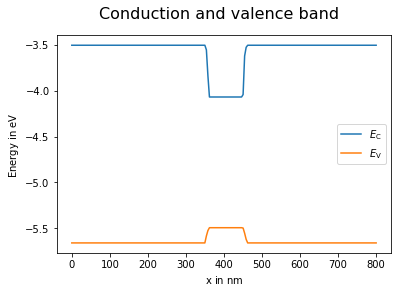

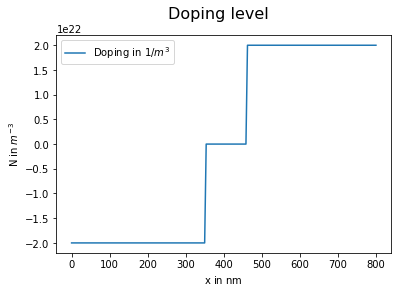

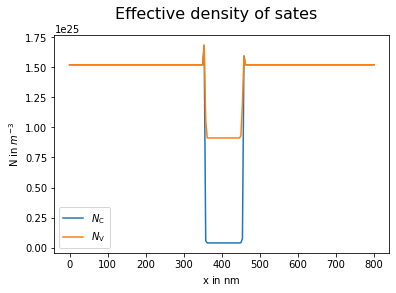

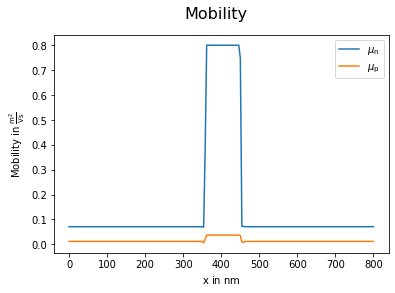

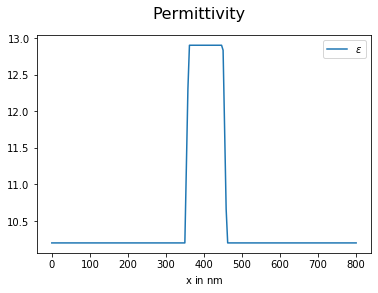

In [3]:
parameters.n = 200
parameters.lx = 800E-9

parameters.init_geometry()

parameters.init_parameters()

# The following combinations work:
# 0.75 / 0.30
# 0.35 / 0.0
# 1.0 / 0.60
# There is an issue for transistions at Al=0.4!

# Al content outside the quantum well
Al1 = .95 # must not be grater than 0.95!
# Al content in the quantum well
Al2 = .00 #.30

#Doping outside the quantum well

Na = -2E22
Nd = +2E22

x1 = 350E-9
x2 = 360E-9
x3 = 450E-9
x4 = 460E-9

for i in range(0, parameters.n):
    if parameters.pos_x[i] < x1:
        parameters.Chi[i] = material_AlGaAs(Al1)["Chi"]
        parameters.Eg[i] = material_AlGaAs(Al1)["Eg"]
        parameters.Nc[i] = material_AlGaAs(Al1)["Nc"]
        parameters.Nv[i] = material_AlGaAs(Al1)["Nv"]
        parameters.Epsilon[i] = material_AlGaAs(Al1)["Er"] * parameters.Epsilon_0
        parameters.mu_n[i] = material_AlGaAs(Al1)["mu_n"]
        parameters.mu_p[i] = material_AlGaAs(Al1)["mu_p"]
        parameters.C[i] = Na
        
    elif parameters.pos_x[i] < x2:
        Alx = Al1 + (Al2 - Al1) / (x2-x1) * (parameters.pos_x[i] - x1)
        
        parameters.Chi[i] = material_AlGaAs(Alx)["Chi"]     
        parameters.Eg[i] = material_AlGaAs(Alx)["Eg"] 
        parameters.Nc[i] = material_AlGaAs(Alx)["Nc"]
        parameters.Nv[i] = material_AlGaAs(Alx)["Nv"] 
        parameters.Epsilon[i] = material_AlGaAs(Alx)["Er"] * parameters.Epsilon_0
        parameters.mu_n[i] = material_AlGaAs(Alx)["mu_n"]
        parameters.mu_p[i] = material_AlGaAs(Alx)["mu_p"]
        parameters.C[i]  = 0.
        
    elif parameters.pos_x[i] < x3:
        parameters.Chi[i] = material_AlGaAs(Al2)["Chi"]
        parameters.Eg[i] = material_AlGaAs(Al2)["Eg"]
        parameters.Nc[i] = material_AlGaAs(Al2)["Nc"]
        parameters.Nv[i] = material_AlGaAs(Al2)["Nv"]
        parameters.Epsilon[i] = material_AlGaAs(Al2)["Er"] * parameters.Epsilon_0
        parameters.mu_n[i] = material_AlGaAs(Al2)["mu_n"]
        parameters.mu_p[i] = material_AlGaAs(Al2)["mu_p"]
        parameters.C[i]  = 0.

    elif parameters.pos_x[i] < x4:
        Alx = Al2 + (Al1 - Al2) / (x4-x3) * (parameters.pos_x[i] - x3)
        parameters.Chi[i] = material_AlGaAs(Alx)["Chi"]
        parameters.Eg[i] = material_AlGaAs(Alx)["Eg"] 
        parameters.Nc[i] = material_AlGaAs(Alx)["Nc"] 
        parameters.Nv[i] = material_AlGaAs(Alx)["Nv"]
        parameters.Epsilon[i] = material_AlGaAs(Alx)["Er"] * parameters.Epsilon_0
        parameters.mu_n[i] = material_AlGaAs(Alx)["mu_n"]
        parameters.mu_p[i] = material_AlGaAs(Alx)["mu_p"]
        parameters.C[i]  = 0.
        
        
    else:
        parameters.Chi[i] = material_AlGaAs(Al1)["Chi"]
        parameters.Eg[i] = material_AlGaAs(Al1)["Eg"]
        parameters.Nc[i] = material_AlGaAs(Al1)["Nc"]
        parameters.Nv[i] = material_AlGaAs(Al1)["Nv"]
        parameters.Epsilon[i] = material_AlGaAs(Al1)["Er"] * parameters.Epsilon_0
        parameters.mu_n[i] = material_AlGaAs(Al1)["mu_n"]
        parameters.mu_p[i] = material_AlGaAs(Al1)["mu_p"]
        parameters.C[i] = Nd
    
#
# Plot conduction and valence band
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence band", fontsize=16)

axis.plot(1E9*parameters.pos_x, -parameters.Chi, label=r'$E_\mathrm{C}$')
axis.plot(1E9*parameters.pos_x, -parameters.Chi - parameters.Eg, label=r'$E_\mathrm{V}$')

plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"Energy in $\mathrm{eV}$")

#plt.ylim(-.4, 2.4)

axis.legend()
plt.savefig("Conduction_and_Valence_Band.png")
plt.show()

#
# Plot doping level
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Doping level", fontsize=16)

axis.plot(1E9*parameters.pos_x, parameters.C, label=r'Doping in $1/m^3$')


plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"N in $m^{-3}$")

#plt.ylim(-.4, 2.4)

axis.legend()
plt.show()

#
# Plot effective density of sates
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Effective density of sates", fontsize=16)

axis.plot(1E9*parameters.pos_x, parameters.Nc, label=r'$N_\mathrm{C}$')
axis.plot(1E9*parameters.pos_x, parameters.Nv, label=r'$N_\mathrm{V}$')

plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"N in $m^{-3}$")

#plt.ylim(-.4, 2.4)

axis.legend()
plt.show()

#
# Plot mobility
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Mobility", fontsize=16)

axis.plot(1E9*parameters.pos_x, parameters.mu_n, label=r'$\mu_\mathrm{n}$')
axis.plot(1E9*parameters.pos_x, parameters.mu_p, label=r'$\mu_\mathrm{p}$')

plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"Mobility in $\mathrm{\frac{m^2}{Vs}}$")

#plt.ylim(-.4, 2.4)

axis.legend()
plt.show()

#
# Plot permittivity
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Permittivity", fontsize=16)

axis.plot(1E9*parameters.pos_x, parameters.Epsilon / parameters.Epsilon_0, label=r'$\varepsilon$')


plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"")

#plt.ylim(-.4, 2.4)

axis.legend()
plt.show()

## Calculate the potential and quasi Fermi levels without biasing
Comment: the norm of $\delta x$ is about $0.17$ after 20 iterations!

In [4]:
parameters.Cau = np.full(parameters.n, 1E-12)

solver.solve_from_doping()
print("after: solve_from_doping()")
solver.solve_no_bias()
print("after: solve_no_bias()")
solver.solve_bias(0,0)

after: solve_from_doping()
after: solve_no_bias()


/home/pabele/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


True

## Plot the results
* band diagram (comment: the quasi-Fermi-level are not constant without biasing, this is an error in the simulation!),
* electron and hole density,
* electron and hole current density

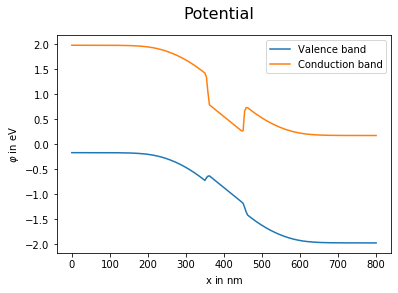

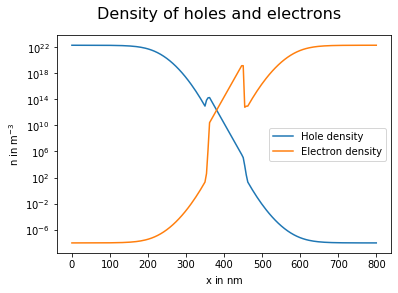

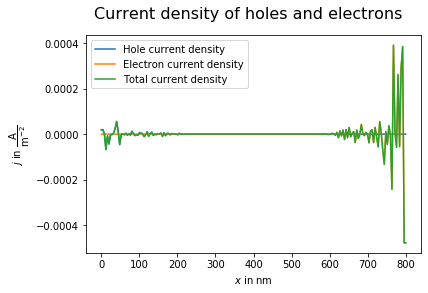

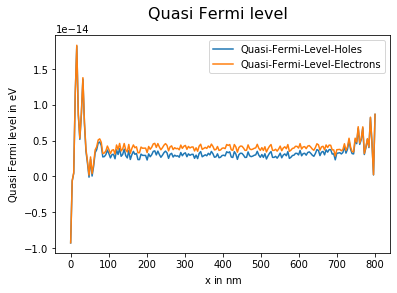

In [5]:
#
# Plot band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Potential", fontsize=16)

plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"$\varphi$ in $\mathrm{eV}$")

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')
#axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3]                                  , label='Quasi-Fermi-level of holes')
#axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3]                                  , label='Quasi-Fermi-level of electrons')

axis.legend()
plt.savefig("Band_Diagram.png")
plt.show()

#
# Plot electron and hole density
#
p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"n in $\mathrm{m^{-3}}$")

axis.semilogy(parameters.pos_x*1E9, p, label='Hole density')
axis.semilogy(parameters.pos_x*1E9, n, label='Electron density')
axis.legend()
plt.show()

#
# Electron and hole current density 
#
j_p =     hole_current_density()
j_n = electron_current_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of holes and electrons", fontsize=16)

plt.xlabel(r"$x$ in $\mathrm{nm}$")
plt.ylabel(r"$j$ in $\mathrm{\dfrac{A}{m^{-2}}}$")

axis.plot(parameters.pos_x*1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x*1E9, j_n, label='Electron current density')
axis.plot(parameters.pos_x*1E9, j_n + j_p, label='Total current density')
axis.legend()
plt.show()

#
# Plot quasi Fermi level
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Quasi Fermi level", fontsize=16)

#axis.plot(parameters.u[0::3], label='Totoal current')
axis.plot(parameters.pos_x*1E9, parameters.u[1::3], label='Quasi-Fermi-Level-Holes')
axis.plot(parameters.pos_x*1E9, parameters.u[2::3], label='Quasi-Fermi-Level-Electrons')
plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"Quasi Fermi level in $\mathrm{eV}$")
axis.legend()
plt.show()

## Simuate a voltage sweep
Now let's simulate a voltage sweep to get the diode characteristic. <br>
For the simulation to converge, the voltage must be ramped up slowly.<br>
The bias points are printed and stored in the arrays **voltage** and **current_density**.

In [6]:
u_actual = 0.0
u_stop    = 3.0
u_step    = 0.1
voltage = []
current_density = []

while (u_actual<=u_stop):

    old_u = parameters.u.copy() # used 
    step_back = 0.0
    while (True):
        print("Voltage:", u_actual + u_step/2**step_back)
        if (solver.solve_bias(u_actual + u_step/2**step_back,0) == True):
            
            u_actual = u_actual + u_step/2**step_back
            break
            
        parameters.u = old_u.copy()
        step_back    = step_back + 1.0   
        
    j = np.mean(hole_current_density() + electron_current_density())
    voltage.append(u_actual)
    current_density.append(j)
    print("Voltage:", u_actual, "and current density:", j)
  

Voltage: 0.1
Voltage: 0.1 and current density: 8.870532121162634e-06
Voltage: 0.2
Voltage: 0.2 and current density: 2.8589899442510013e-06
Voltage: 0.30000000000000004
Voltage: 0.30000000000000004 and current density: 5.60389585281742e-06
Voltage: 0.4
Voltage: 0.4 and current density: -1.7829863736480706e-05
Voltage: 0.5
Voltage: 0.5 and current density: -2.6518136451838985e-07
Voltage: 0.6
Voltage: 0.6 and current density: 0.0008317265057671913
Voltage: 0.7
Voltage: 0.7 and current density: 0.03936176076805363
Voltage: 0.7999999999999999
Voltage: 0.7999999999999999 and current density: 1.8675816371853904
Voltage: 0.8999999999999999
Voltage: 0.8999999999999999 and current density: 79.69841286344163
Voltage: 0.9999999999999999
Voltage: 0.9999999999999999 and current density: 1360.3038273555583
Voltage: 1.0999999999999999
Voltage: 1.0999999999999999 and current density: 9724.969317897132
Voltage: 1.2
Voltage: 1.2 and current density: 56343.52326518492
Voltage: 1.3
Voltage: 1.3 and curren

## Plot the diode characteristsics

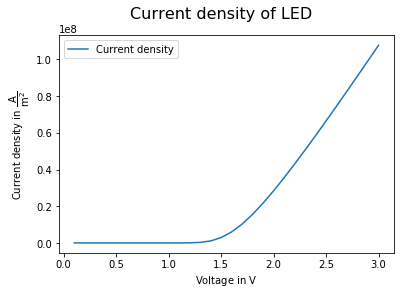

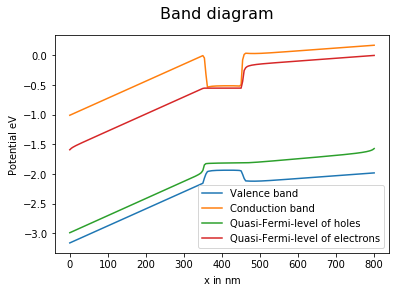

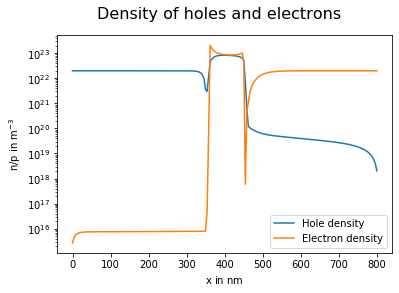

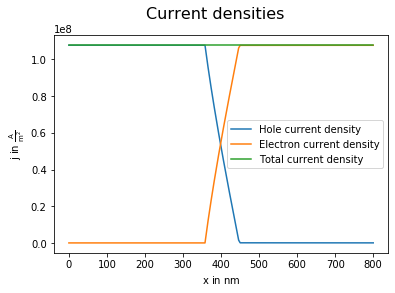

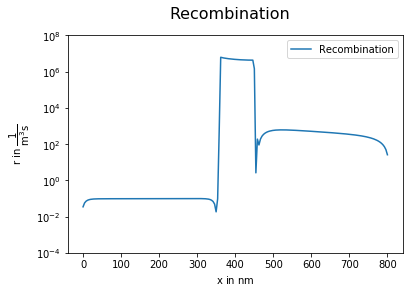

In [7]:
#
# Plot diode characteristic
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of LED", fontsize=16)

axis.plot(voltage, current_density, label='Current density')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

axis.legend()
#plt.ylim(-1E7,1E7)
plt.savefig("Diode_Characteristic.png")
plt.show()

#
# Plot band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3]                                  , label='Quasi-Fermi-level of holes')
axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3]                                  , label='Quasi-Fermi-level of electrons')

plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"Potential $\mathrm{eV}$")

axis.legend()
plt.show()

#
# Plot electron and hole density
#
p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

#plt.ylim(1E20)

axis.semilogy(parameters.pos_x*1E9, p, label='Hole density')
axis.semilogy(parameters.pos_x*1E9, n, label='Electron density')

plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"n/p in $\mathrm{m^{-3}}$")

axis.legend()
plt.show()

#
# Plot current densities
#
j_p =     hole_current_density()
j_n = electron_current_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current densities", fontsize=16)

axis.plot(parameters.pos_x*1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x*1E9, j_n, label='Electron current density')
axis.plot(parameters.pos_x*1E9, j_n + j_p, label='Total current density')
plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"j in $\mathrm{\frac{A}{m^2}}$")
axis.legend()
plt.savefig("Current_Density.png")
plt.show()

#
# Plot recombination rate
#
calc_recombination()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Recombination", fontsize=16)

axis.semilogy(1E9*parameters.pos_x,
            parameters.q*calc_recombination()*parameters.dx,
            label='Recombination')

plt.xlabel(r"x in $\mathrm{nm}$")
plt.ylabel(r"r in $\mathrm{\dfrac{1}{m^3 s}}$")

plt.ylim(1E-4, 1E8)
axis.legend()
plt.savefig("Recombination_Rate.png")
plt.show()